In [1]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from lightgbm import LGBMRegressor
from lightgbm import LGBMClassifier
import gc
from sklearn.preprocessing import normalize
import torch
from sklearn.decomposition import TruncatedSVD
from sklearn.svm import NuSVR,SVR
from collections import Counter
from sklearn.metrics import cohen_kappa_score

In [2]:
def MCRMSE(y_trues, y_preds):
    scores = []
    idxes = y_trues.shape[1]
    for i in range(idxes):
        y_true = y_trues[:,i]
        y_pred = y_preds[:,i]
        score = mean_squared_error(y_true, y_pred, squared=False) # RMSE
        scores.append(score)
    mcrmse_score = np.mean(scores)
    return mcrmse_score, scores

def get_score(y_trues, y_preds):
    mcrmse_score, scores = MCRMSE(y_trues, y_preds)
    return mcrmse_score, scores
def get_data(state):
    X_train,y_train,X_val,y_val,XX_train,XX_val = state['EMB_train'],state['train_labels'],state['EMB'],state['valid_labels'],state['EMB_train_real'],state['EMB_real']
    X = np.concatenate([X_train,X_val])
    svd = TruncatedSVD(n_components=128)
    EMB = svd.fit_transform(X)
    X_train_svd = EMB[:len(X_train)]
    X_val_svd = EMB[len(X_train):]
    return X_train,y_train,X_val,y_val,X_train_svd,X_val_svd,XX_train,XX_val
def train_lbg_reg(X_train_svd,y_train,X_val_svd,y_val):
    model = LGBMRegressor(learning_rate=0.1,n_estimators =500,reg_lambda = 0.5)
    model.fit(X_train_svd, y_train,eval_set=(X_val_svd, y_val),verbose=250,early_stopping_rounds=20)
    pred = model.predict(X_val_svd)
    return pred
def train_lbg_cla(X_train_svd,y_train,X_val_svd,y_val):
    w = np.array([np.count_nonzero(y_train.round().astype(int)-1 == row) for row in range(5)])
    class_weight = {0:w[0],1:w[1],2:w[2],4:w[3]*100,4:w[4]*10}
    model = LGBMClassifier(learning_rate=0.1,n_estimators =300,reg_lambda = 0.5,class_weight = class_weight)
    model.fit(X_train_svd, y_train.round().astype(int)-1,eval_set=(X_val_svd, y_val.round().astype(int)-1),verbose=250,early_stopping_rounds=20)
    pred = model.predict(X_val_svd)
    return pred

In [3]:
path = 'outputs_baseline/Narrativaai.deberta-v3-small-finetuned-hate_speech18'
model = 'Narrativaai-deberta-v3-small-finetuned-hate_speech18'
FOLDS = 4

In [4]:
state = torch.load(f"{path}/{model}_fold0_best.pth")
state.keys()

dict_keys(['model', 'predictions', 'EMB_train_real', 'EMB_real', 'EMB', 'valid_labels', 'EMB_train', 'valid_folds', 'train_labels', 'train_folds'])

# Train Regressor On Embeddings from pre-trin

In [5]:
output_reg_real = {}
pred_reg = []
val_reg = []
for fold in range(FOLDS):
    state = torch.load(f"{path}/{model}_fold{fold}_best.pth")
    X_train,y_train,X_val,y_val,X_train_svd,X_val_svd,XX_train,XX_val = get_data(state)
    pred_lbg_reg = train_lbg_reg(XX_train,y_train.ravel(),XX_val,y_val.ravel())
    score_lbg_reg = get_score(y_val.reshape(-1,1),pred_lbg_reg.reshape(-1,1))
    output_reg_real[f'fold_{fold}_score'] = score_lbg_reg[0]
    pred_reg = pred_reg + list(pred_lbg_reg.reshape(-1))
    val_reg = val_reg + list(y_val)
cv = get_score(np.array(val_reg).reshape(-1,1),np.array(pred_reg).reshape(-1,1))
output_reg_real['cv_score'] = cv[0]
output_reg_real

/home/kaor/.local/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaor/.local/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaor/.local/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds'

{'fold_0_score': 0.9246547577568621,
 'fold_1_score': 0.9069779920491029,
 'fold_2_score': 0.9094726974228095,
 'fold_3_score': 0.9092474416210352,
 'cv_score': 0.9126150247330902}

# Train Regressor On Embeddings After fine tune

In [6]:
output_reg = {}
pred_reg = []
val_reg = []
for fold in range(FOLDS):
    state = torch.load(f"{path}/{model}_fold{fold}_best.pth")
    X_train,y_train,X_val,y_val,X_train_svd,X_val_svd,_,_ = get_data(state)
    pred_lbg_reg = train_lbg_reg(X_train_svd,y_train.ravel(),X_val_svd,y_val.ravel())
    score_lbg_reg = get_score(y_val.reshape(-1,1),pred_lbg_reg.reshape(-1,1))
    output_reg[f'fold_{fold}_score'] = score_lbg_reg[0]
    pred_reg = pred_reg + list(pred_lbg_reg.reshape(-1))
    val_reg = val_reg + list(y_val)
cv = get_score(np.array(val_reg).reshape(-1,1),np.array(pred_reg).reshape(-1,1))
output_reg['cv_score'] = cv[0]
output_reg

/home/kaor/.local/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaor/.local/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaor/.local/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds'

{'fold_0_score': 0.841654984927485,
 'fold_1_score': 0.8336277130975779,
 'fold_2_score': 0.8242548938440667,
 'fold_3_score': 0.8149488569899014,
 'cv_score': 0.828681657072699}

# Train Classifier On Embeddings from pre-trin

/home/kaor/.local/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaor/.local/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaor/.local/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds'

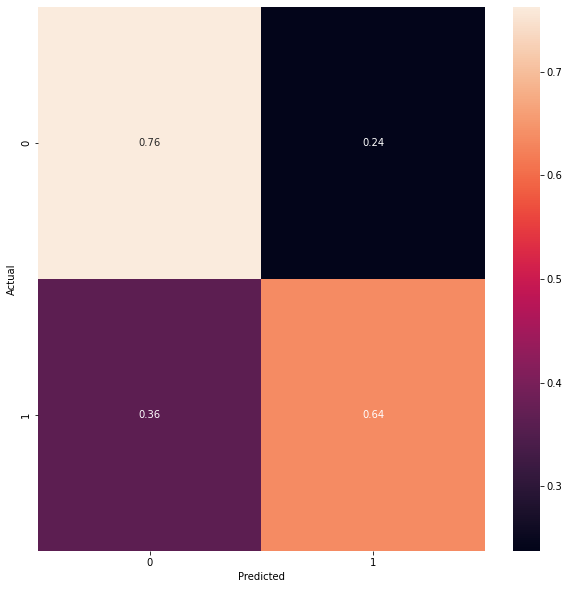

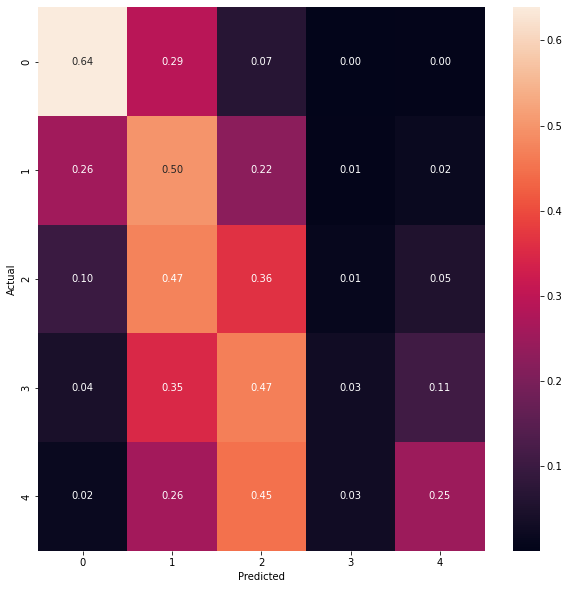

{'fold_0_score': 0.399604743083004,
 'fold_1_score': 0.4114624505928854,
 'fold_2_score': 0.38798893717898064,
 'fold_3_score': 0.39644268774703556,
 'cv_score_acc': 0.39887362908803475,
 'cv_score_kappa': 0.20818815824986703}

In [7]:
output_cla_real = {}
pred_cla = []
val_cla = []
for fold in range(FOLDS):
    state = torch.load(f"{path}/{model}_fold{fold}_best.pth")
    X_train,y_train,X_val,y_val,X_train_svd,X_val_svd,XX,XX_val = get_data(state)
    pred_lbg_cla = train_lbg_cla(XX,y_train.ravel(),XX_val,y_val.ravel())
    score_lbg_cla = accuracy_score(y_val.round().astype(int)-1,pred_lbg_cla)
    output_cla_real[f'fold_{fold}_score'] = score_lbg_cla
    val_cla = val_cla + list(y_val)
    pred_cla = pred_cla + list(pred_lbg_cla.reshape(-1))
cv = accuracy_score(np.array(val_cla).round().astype(int)-1,np.array(pred_cla))
output_cla_real['cv_score_acc'] = cv
output_cla_real['cv_score_kappa']  = cohen_kappa_score(np.array(val_cla).round().astype(int)-1,np.array(pred_cla))
cm = confusion_matrix(np.array(val_cla).round().astype(int)-1>2,np.array(pred_cla)>1)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)
cm = confusion_matrix(np.array(val_cla).round().astype(int)-1,np.array(pred_cla))
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)
output_cla_real

# Train Classifier On Embeddings After fine tune

/home/kaor/.local/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaor/.local/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaor/.local/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds'

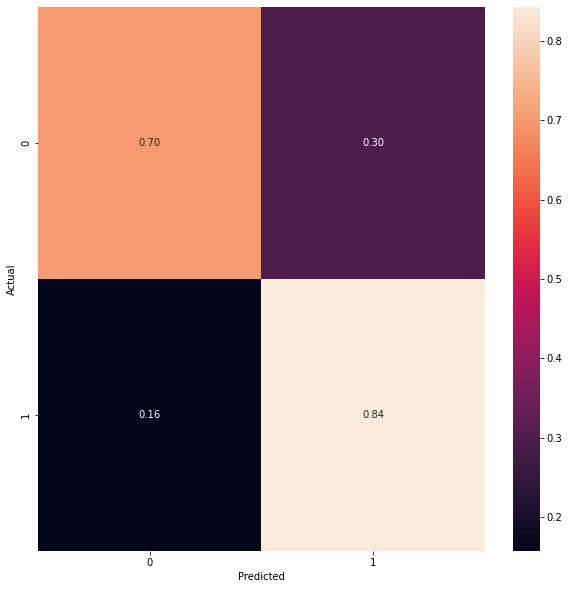

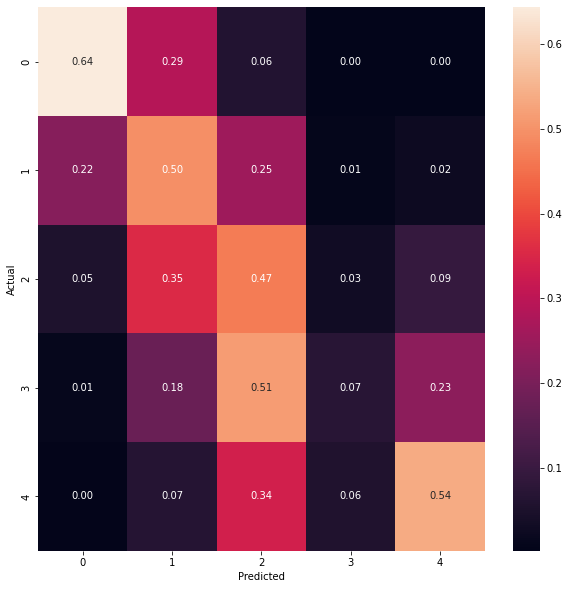

{'fold_0_score': 0.44189723320158103,
 'fold_1_score': 0.4474308300395257,
 'fold_2_score': 0.4381667325167918,
 'fold_3_score': 0.46482213438735176,
 'cv_score_acc': 0.4480782531370418,
 'cv_score_kappa': 0.2860893297238205}

In [8]:
output_cla = {}
pred_cla = []
val_cla = []
for fold in range(FOLDS):
    state = torch.load(f"{path}/{model}_fold{fold}_best.pth")
    X_train,y_train,X_val,y_val,X_train_svd,X_val_svd,XX,XX_val = get_data(state)
    pred_lbg_cla = train_lbg_cla(X_train_svd,y_train.ravel(),X_val_svd,y_val.ravel())
    score_lbg_cla = accuracy_score(y_val.round().astype(int)-1,pred_lbg_cla)
    output_cla[f'fold_{fold}_score'] = score_lbg_cla
    val_cla = val_cla + list(y_val)
    pred_cla = pred_cla + list(pred_lbg_cla.reshape(-1))
cv = accuracy_score(np.array(val_cla).round().astype(int)-1,np.array(pred_cla))
output_cla['cv_score_acc'] = cv
output_cla['cv_score_kappa']  = cohen_kappa_score(np.array(val_cla).round().astype(int)-1,np.array(pred_cla))
cm = confusion_matrix(np.array(val_cla).round().astype(int)-1>2,np.array(pred_cla)>1)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)
cm = confusion_matrix(np.array(val_cla).round().astype(int)-1,np.array(pred_cla))
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)
output_cla

In [9]:
output_reg_real,output_reg

({'fold_0_score': 0.9246547577568621,
  'fold_1_score': 0.9069779920491029,
  'fold_2_score': 0.9094726974228095,
  'fold_3_score': 0.9092474416210352,
  'cv_score': 0.9126150247330902},
 {'fold_0_score': 0.841654984927485,
  'fold_1_score': 0.8336277130975779,
  'fold_2_score': 0.8242548938440667,
  'fold_3_score': 0.8149488569899014,
  'cv_score': 0.828681657072699})

In [10]:
output_cla_real,output_cla

({'fold_0_score': 0.399604743083004,
  'fold_1_score': 0.4114624505928854,
  'fold_2_score': 0.38798893717898064,
  'fold_3_score': 0.39644268774703556,
  'cv_score_acc': 0.39887362908803475,
  'cv_score_kappa': 0.20818815824986703},
 {'fold_0_score': 0.44189723320158103,
  'fold_1_score': 0.4474308300395257,
  'fold_2_score': 0.4381667325167918,
  'fold_3_score': 0.46482213438735176,
  'cv_score_acc': 0.4480782531370418,
  'cv_score_kappa': 0.2860893297238205})